## Overview

#### The goal of this project is to create an algorithm to identify metastatic cancer in small impage patches taken from larger digital pathology scans. The data used is a slightly modified version of the PatchCamelyon (PCam) benchmark set.

#### This is a binary classification problem to analyze digital images of 96 px X 96 px. 

#### The data set was downloaded from https://www.kaggle.com/c/histopathologic-cancer-detection/data

## Importing libraries

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os


In [2]:
print(os.getcwd())

/Users/johnkaiser/Documents/MSDS/Spring 2024/5511 Deep Learning


## Import data and begin EDA

In [3]:
path = 'histopathologic-cancer-detection'
train_labels = pd.read_csv(f'{path}/train_labels.csv')
train_path = f'{path}/train'
test_path = f'{path}/test'

print('Data Frame Description: \n \n', train_labels.describe(include='all'), '\n \n')
print('DF shape: ', train_labels.shape, '\n \n')
print('Data Types: \n \n', train_labels.dtypes, '\n \n')
train_length = len(os.listdir(train_path))
test_length = len(os.listdir(test_path))
print('Total train files: ', train_length)
print('Total test files: ', test_length, '\n \n')
print(train_labels.head(10), '\n \n')
print('Total Cancerous (1): ', sum(train_labels['label']==1))
print('Total Non-Cancerous (0): ', sum(train_labels['label']==0))

Data Frame Description: 
 
                                               id          label
count                                     220025  220025.000000
unique                                    220025            NaN
top     f38a6374c348f90b587e046aac6079959adf3835            NaN
freq                                           1            NaN
mean                                         NaN       0.405031
std                                          NaN       0.490899
min                                          NaN       0.000000
25%                                          NaN       0.000000
50%                                          NaN       0.000000
75%                                          NaN       1.000000
max                                          NaN       1.000000 
 

DF shape:  (220025, 2) 
 

Data Types: 
 
 id       object
label     int64
dtype: object 
 

Total train files:  220025
Total test files:  57458 
 

                                         id  label


## Initial findings in the data:

* We see in the data frame description that there are 220,025 observations with all of them being unique. 
* There are 2 columns, 'id' contains the matching id with an image in the 'train' folder and 'label' is a binary integer representing 0 as false (non cancerous) and 1 as true (cancerous)
* Currently, 'id' is an object data type but we can make that a string. 'label' is currently an integer but we can make that a factor
* In the 2 folders from the downloaded data set, there are 220,025 in the 'train' folder corresponding to the id's in the data frame. The 'test' folder has 57,458
* For value counts of 'label', we can see there are many more non-cancerous (0) labels than cancerous. 130,908 to 89,117, respectively.

[Text(0, 0, '59.5%'), Text(0, 0, '40.5%')]

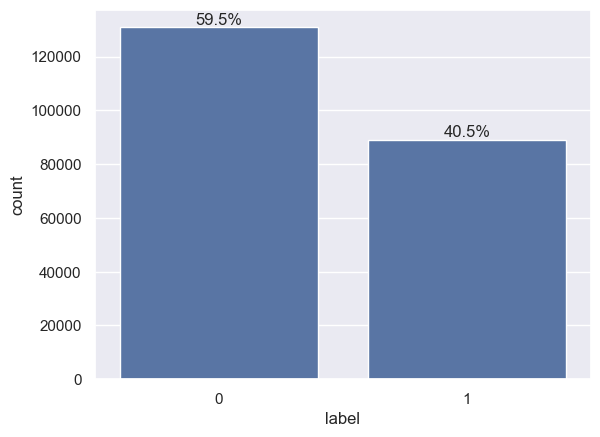

In [4]:
p = sns.countplot(data=train_labels, x='label')
p.bar_label(p.containers[0], fmt=lambda x: f'{(x/train_length)*100:0.1f}%')

## Observing the data

#### Below, I select 12 random images from the training data to plot and assign their labels. To the untrained eye, it would be difficult to distinguish the difference between cancerous cells and non-cancerous cells. We can also see under the images that the image size is 96 x 96 x 3.

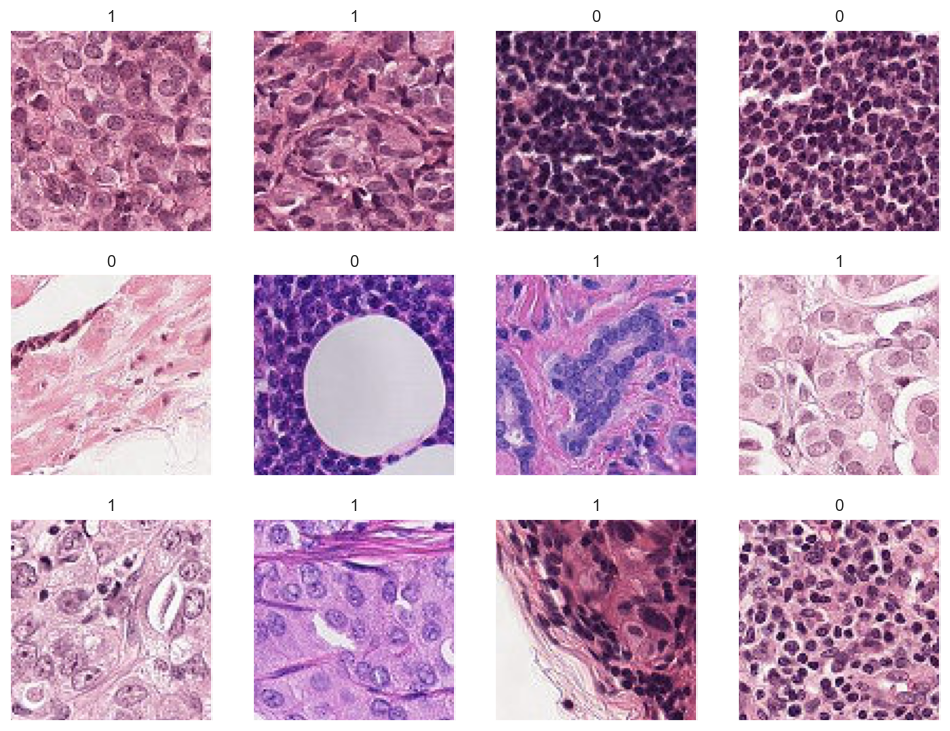

In [5]:
import matplotlib.image as mpimg

np.random.seed(42)
fig = plt.figure(figsize=(12,9), dpi=100)
for p, i in enumerate(np.random.randint(0, train_length, 12)):
   ax = fig.add_subplot(3, 12//3, p+1, xticks=[], yticks=[])
   plt.imshow(mpimg.imread(f'{train_path}/{train_labels.iloc[i, 0]}.tif'))
   ax.set_title(f'{train_labels.iloc[i, 1]}')

In [6]:
img = mpimg.imread(f'{train_path}/{train_labels.iloc[0,0]}.tif')
print('Image shape: ', img.shape)

Image shape:  (96, 96, 3)


## Model Architecture

In [18]:

#!pip install tensorflow==2.15.0
#!pip install keras
#!pip install tensorflow-metal==0.7.0
#!pip install tensorflow-macos
import keras
from keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [ ]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /Users/johnkaiser/miniconda/envs/tensorflow/lib/python3.9/site-packages
Requires: 
Required-by: tensorflow-macos


#### I reduced the size of the training data to 160,000 images to save time on training and have even amounts with batches of size 32.

In [19]:
sample_size = 160000
train_sample = train_labels.sample(sample_size, random_state=42)
train_sample.shape

(160000, 2)

#### Append the '.tif' file extension to the training 'id' and change 'label' to string

In [20]:
train_sample['id'] = train_sample['id']+'.tif'

In [21]:
train_sample['label'] = train_sample['label'].astype(str)

#### Next, we can use the ImageDataGenerator class in Keras for the model to access the training data from the 'train' directory. I used a 20% validation split for training and set class_mode to binary. 

In [22]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=train_sample,
                                        directory=train_path,
                                        x_col='id',
                                        y_col='label',
                                        subset='training',
                                        class_mode='binary',
                                        batch_size=32,
                                        shuffle=True,
                                        seed=42,
                                        target_size=(96,96))

valid_gen = datagen.flow_from_dataframe(dataframe=train_sample,
                                        directory=train_path,
                                        x_col='id',
                                        y_col='label',
                                        subset='validation',
                                        class_mode='binary',
                                        batch_size=32,
                                        shuffle=True,
                                        seed=42,
                                        target_size=(96,96))

Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


#### For the structure of the model, I played around with a few different designs based off of the Sequential model. Here, I did 3 blocks with 3 CNN layers each. Filter size of 3x3 with the first layer having 32 filters, the second with 64 and the third with 128. Each uses 'reLU' activation and includes max pooling with 2x2 filters and a batch normalization. After the 3 layers, I added a flatten layer, 3 dropout layers and 3 dense layers before the final sigmoid dense output layer. 

In [27]:
filter_size = (3,3)
pooling = (2,2)
first = 32
second = 64
third = 128
fourth = 256

model = Sequential()
model.add(Conv2D(first, filter_size, padding='same', activation='relu', input_shape=(96, 96, 3)))
model.add(Conv2D(first, filter_size, activation='relu'))
model.add(Conv2D(first, filter_size, activation='relu'))
model.add(MaxPool2D(pool_size=pooling))
model.add(BatchNormalization())

model.add(Conv2D(second, filter_size, activation='relu'))
model.add(Conv2D(second, filter_size, activation='relu'))
model.add(Conv2D(second, filter_size, activation='relu'))
model.add(MaxPool2D(pool_size=pooling))
model.add(BatchNormalization())

model.add(Conv2D(third, filter_size, activation='relu'))
model.add(Conv2D(third, filter_size, activation='relu'))
model.add(Conv2D(third, filter_size, activation='relu'))
model.add(MaxPool2D(pool_size=pooling))
model.add(BatchNormalization())

# model.add(Conv2D(fourth, filter_size, activation='relu'))
# model.add(Conv2D(fourth, filter_size, activation='relu'))
# model.add(Conv2D(fourth, filter_size, activation='relu'))
# model.add(MaxPool2D(pool_size=pooling))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.build((None, 96, 96, 3))
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_60 (ModuleW  (None, 96, 96, 32)        896       
 rapper)                                                         
                                                                 
 module_wrapper_61 (ModuleW  (None, 94, 94, 32)        9248      
 rapper)                                                         
                                                                 
 module_wrapper_62 (ModuleW  (None, 92, 92, 32)        9248      
 rapper)                                                         
                                                                 
 module_wrapper_63 (ModuleW  (None, 46, 46, 32)        0         
 rapper)                                                         
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 32)       

#### When compiling the model, I used Adam optimizer with binary cross entropy loss and set the learning rate to 0.0001.

In [28]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
train_gen.batch_size

32

In [31]:
train_step_size = train_gen.n//train_gen.batch_size
val_step_size = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=train_step_size,
                     validation_data=valid_gen,
                     validation_steps=val_step_size,
                     verbose=1,
                     epochs=12)

Epoch 1/12
4000/4000 [==============================] - 469s 117ms/step - loss: 0.3671 - accuracy: 0.8421 - val_loss: 0.3565 - val_accuracy: 0.8465
Epoch 2/12
4000/4000 [==============================] - 506s 127ms/step - loss: 0.2998 - accuracy: 0.8761 - val_loss: 0.3620 - val_accuracy: 0.8498
Epoch 3/12
4000/4000 [==============================] - 512s 128ms/step - loss: 0.2570 - accuracy: 0.8968 - val_loss: 0.2486 - val_accuracy: 0.8958
Epoch 4/12
4000/4000 [==============================] - 523s 131ms/step - loss: 0.2279 - accuracy: 0.9100 - val_loss: 1.0104 - val_accuracy: 0.7433
Epoch 5/12
4000/4000 [==============================] - 511s 128ms/step - loss: 0.2064 - accuracy: 0.9198 - val_loss: 0.2326 - val_accuracy: 0.9017
Epoch 6/12
4000/4000 [==============================] - 511s 128ms/step - loss: 0.1877 - accuracy: 0.9280 - val_loss: 0.2913 - val_accuracy: 0.8840
Epoch 7/12
4000/4000 [==============================] - 512s 128ms/step - loss: 0.1716 - accuracy: 0.9351 - val_

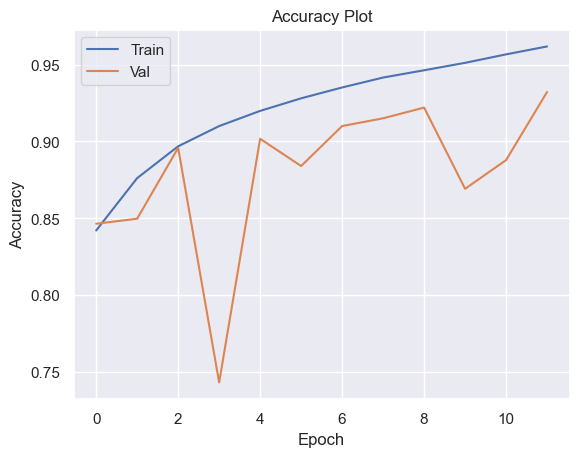

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy Plot')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

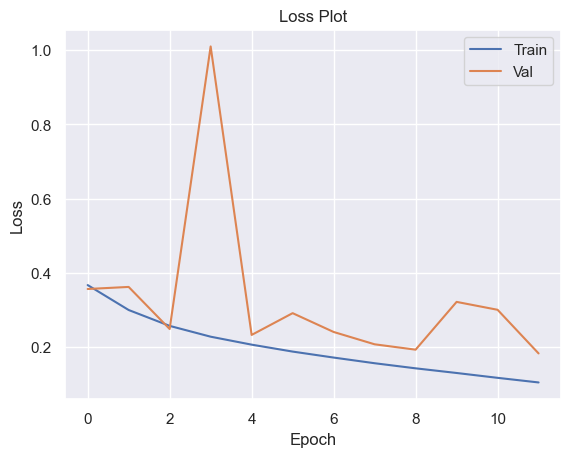

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Plot')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

## Findings and Conclusion

#### I ran into lots of different problems with versions of Tensorflow and model training sessions getting stuck or freezing. I finally had to reinstall version 2.15 of Tensorflow with Python 3.9.16 and got these 12 epochs to run smoothly. Looking at the accuracy and loss plots above, this model performed fairly well but we see that epoch 4 had very bad validation loss and accuracy. With the training accuracy and loss improving but validation accuracy and loss jumping around like it did, that would indicate overfitting and the model not generalizing well to the data. With more time, I would extend the number of epochs and test different hyperparameters such as optimizers, learning rate, and different layers for the model. The accuracy didn't quite flatten out yet with 12 epochs and the loss was still on the decline. 

### Now we can create the test set, predictions from the model and a submission .csv

In [34]:
test_df = pd.DataFrame(os.listdir(test_path))
test_df.columns = ['id']
test_df.head()

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [35]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory=test_path,
                                            x_col='id',
                                            batch_size=64,
                                            seed=42,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(96,96))

Found 57458 validated image filenames.


In [37]:
preds = model.predict(test_gen)

898/898 [==============================] - 49s 55ms/step


In [38]:
predictions = []

for p in preds:
   if p >= 0.5:
      predictions.append(1)
   else:
      predictions.append(0)

predictions[:10]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1]

In [39]:
print(test_df.shape)
print(len(predictions))

(57458, 1)
57458


In [40]:
submission = test_df.copy()
submission['id'] = submission['id'].str[:-4] # remove the '.tif' extension
submission['label'] = predictions
submission.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [41]:
submission.to_csv('submission.csv', index=False)